In [1]:
import os
from srim import TRIM, Target, Layer, Ion, Element

# directory to srim executable
SRIM_EXECUTABLE_DIRECTORY = os.path.abspath('../../srim_install')
DATA_DIRECTORY = os.path.abspath('./SiC/output')

# Define calculations in code
ions = [
    {'identifier': 'Al', 'energy': 150.0e3}, # eV
    {'identifier': 'Au', 'energy': 200.0e3}, # eV
]

layer = Layer({
    'Si': {
        'stoich': 0.5,
        'E_d': 35.0, # Displacement Energy
        'lattice': 4.8,
        'surface': 3.0
    },
    'C': {
        'stoich': 0.5,
        'E_d': 20.0, # Displacement Energy
        'lattice': 7.1,
        'surface': 3.0
    }
}, density=3.21, width=10000.0)
target = Target([layer])

# number of ions to use in each SRIM calculation
# step size should never be larger than 1,000
# if you are storing COLLISON.txt
IONS_PER_STEP = 100
# number of ions to simulate for each ion
NUM_IONS = 1000

# See TRIMSettings and TRIM for full options
# you can do any setting that you could do in TRIM
TRIM_SETTINGS = {
    'calculation': 2, # full cascade
    'collisions': 2,
    'angle_ions': 4,
    'ranges': True,
}

# Run SRIM calcluations for each ion
trim_instance = TRIM(
    ions, 
    target, 
    SRIM_EXECUTABLE_DIRECTORY,
    DATA_DIRECTORY,
    number_ions=NUM_IONS,
    step_size=IONS_PER_STEP,  
    **TRIM_SETTINGS
)

# Run the SRIM calculations
# Argument is number of threads to use
# default is all available threads
trim_instance.apply()

Fragment 2 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/0
Fragment 3 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/1
Fragment 0 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/2
Fragment 1 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/3
Fragment 6 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/4
Fragment 5 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/5
Fragment 4 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/6
Fragment 7 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/7
Fragment 1 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Au/0
Fragment 0 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Au/1
Fragment 7 saved to: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Au/2

In [2]:
from srim.merge import CASCADES
cascades = CASCADES(data_directory=DATA_DIRECTORY)
cascades.merge_collisions()

Initializing CASCADES from /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output
Merged file created at: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Au/COLLISON.txt
Merged file created at: /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/COLLISON.txt


In [3]:
data = cascades.generate_numpy_arrays()
cascades.print_summary()

keys =  dict_keys(['Au', 'Al'])
Symbol: Al	Num Ions:    1000	Collisions: 1199985
|	Median (x, y, z) [nm]: [115.600	4.998	-0.154]
|	Mean   (x, y, z) [nm]: [115.690	7.999	-0.991]

Symbol: Au	Num Ions:    1000	Collisions: 2206819
|	Median (x, y, z) [nm]: [30.360	1.855	-0.047]
|	Mean   (x, y, z) [nm]: [30.867	2.592	-0.014]



In [4]:
import srim.output as out
my_out_Al = out.Collision(f'{DATA_DIRECTORY}/Al')
my_out_Al.write_mmonca(f'{DATA_DIRECTORY}/Al/mmonca.txt')
my_out_Au = out.Collision(f'{DATA_DIRECTORY}/Au')
my_out_Au.write_mmonca(f'{DATA_DIRECTORY}/Au/mmonca.txt')

Conversion complete. MMonCa file saved as /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Al/mmonca.txt
Conversion complete. MMonCa file saved as /home/filipov/Software/SRIM/pysrim/examples/notebooks/SiC/output/Au/mmonca.txt


# Load data from merged files

# Below are some plotting functions which work well with the generated data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_heatmap(ax, data, cols, limits, norm, bins=(1000, 200)):
    """ Plot a heatmap
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    cols : tuple
        tuple or list length 2. example (0, 2) x, z axis
    limits : tuple
        tuple or list (2x2) [[col[0] min, col[0] max], [col[0] min, col[0] max]]
    norm : mpl.colors
        colorbar scale to use
    """
    c1, c2 = cols
    (c1min, c1max), (c2min, c2max) = limits
    region_data = data[(data[:, c1] < c1max) & (data[:, c1] > c1min) & (data[:, c2] < c2max) & (data[:, c2] > c2min)]
    heatmap, xedges, yedges = np.histogram2d(region_data[:, c1], region_data[:, c2], range=limits, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    heatmap[heatmap == 0.0] = np.nan
    colormap = mpl.colormaps['viridis']
    return ax.imshow(heatmap.T, origin='lower', extent=extent, cmap=colormap, norm=norm)
    
def plot_radial_distribution_hist(ax, data, maximum, label):
    """ plot radial distribution of data
    
    Parameters
    ----------
    ax : maptlotlib.axes
        axis to plot heatmap on
    data : np.ndarray
        numpy array that was constructed from 'parse_directory' it is [Nx3] in dimmension.
    maximum : float
        maximum distance to plot radial distribution
    label : str
        label to give for plot
    """
    density, edges = np.histogram(data, bins=100, density=False, range=(1e-8, maximum))
    x = np.linspace(1e-1, maximum, len(density))
    density = [d / (2 * math.pi * r)  for r, d in zip(x, density)]
    # return ax.plot(x, density, label=label)
    return ax.semilogy(x, density, label=label)

In [6]:
# Using Log color scale
# Collect all collision values across all ions
all_collisions = [data[ion]['collisions'] for ion in data]
# all_values = np.concatenate(all_collisions)
# Determine min/max dynamically for both scales
# Assuming the second dimension is also meaningful and should be adapted
vertical_dim_values = np.array([point[0] for collisions in all_collisions for point in collisions])
min_vert, max_vert = np.min(vertical_dim_values), np.max(vertical_dim_values)
radial_dim_values = np.array([point[1] for collisions in all_collisions for point in collisions])
min_radial, max_radial = np.min(radial_dim_values), np.max(radial_dim_values)
print(min_vert, max_vert, min_radial, max_radial)

1e-05 290.7 -179.7 156.6


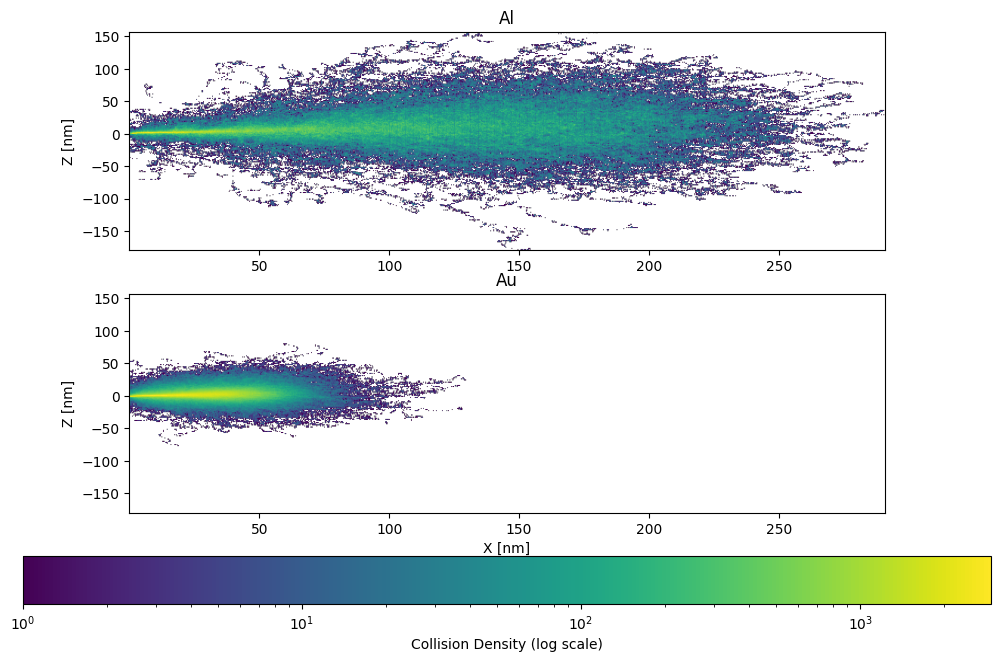

In [7]:
sort_by_mass = lambda e1: Element(e1).mass

# Set dynamically calculated limits
limits = [[min_vert, max_vert], [min_radial, max_radial]]
bins = (1000, 200)

# Ensure ions is iterable and get the number of subplots needed
num_ions = len(ions)

# Handle case where there is only one ion
if num_ions == 1:
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))  # Reduce height for single ion
    axes = [ax]  
else:
    fig, axes = plt.subplots(num_ions, 1, figsize=(25, 4 * num_ions))  # Increase height dynamically
    plt.subplots_adjust(hspace=0.2)  # Add more vertical space

for ax, ion in zip(axes, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (0, 1), limits, norm, bins=bins)
    ax.set_title(ion)
    ax.set_aspect(1/(2 * num_ions))  # Keep heatmap from getting too thin
    ax.set_ylabel('Z [nm]')

# Ensure only the last subplot has an X-axis label
axes[-1].set_xlabel('X [nm]')

# Add a horizontal colorbar at the bottom, with padding
cbar = fig.colorbar(im, ax=axes[:num_ions], location="bottom", shrink=0.5, pad=0.07)
cbar.set_label("Collision Density (log scale)")

IMAGE_DIRECTORY = os.path.join(DATA_DIRECTORY, '../images/')
os.makedirs(IMAGE_DIRECTORY, exist_ok=True)

# Save figure
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-length-heatmap-log.png'), transparent=False, dpi=300)

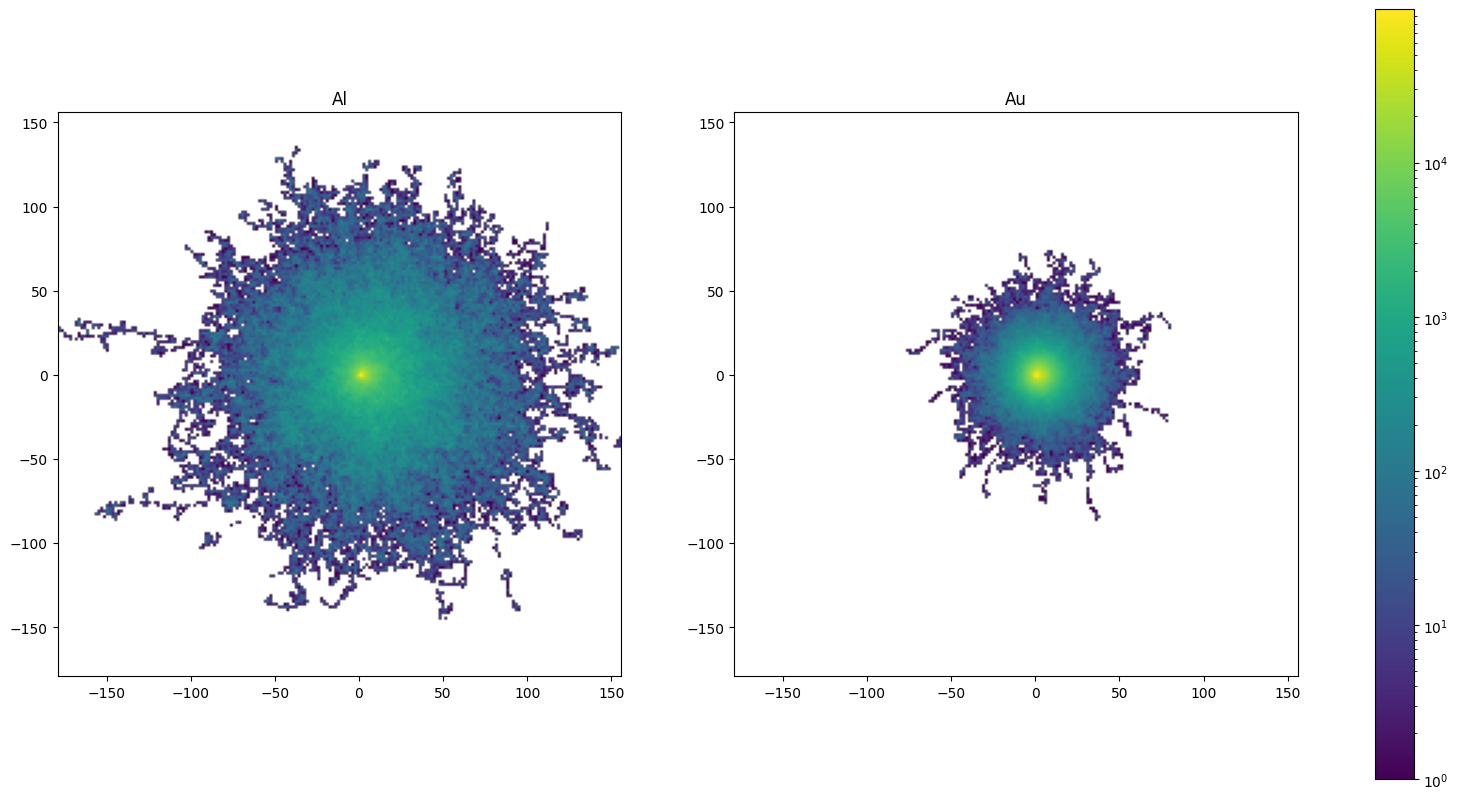

In [8]:
# Using Log color scale
limits = [[int(min_radial), int(max_radial)], [int(min_radial), int(max_radial)]]
bins = (200, 200)

# Determine optimal grid size
num_cols = min(3, num_ions)  # Up to 3 columns for better layout
num_rows = int(np.ceil(num_ions / num_cols))  # Adjust rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
axes = np.array(axes).reshape(-1)  # Flatten in case of 1D array

for ax, ion in zip(axes, sorted(data, key=sort_by_mass)):
    norm = mpl.colors.LogNorm()
    im = plot_heatmap(ax, data[ion]['collisions'], (1, 2), limits, norm, bins=bins)
    ax.set_title(ion)

# Remove extra empty subplots
for ax in axes[num_ions:]:
    fig.delaxes(ax)

# Add a single colorbar for all subplots
fig.colorbar(im, ax=axes[:num_ions], location="right")

fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-heatmap-log.png'), transparent=False, dpi=300)

0 Al
1 Au


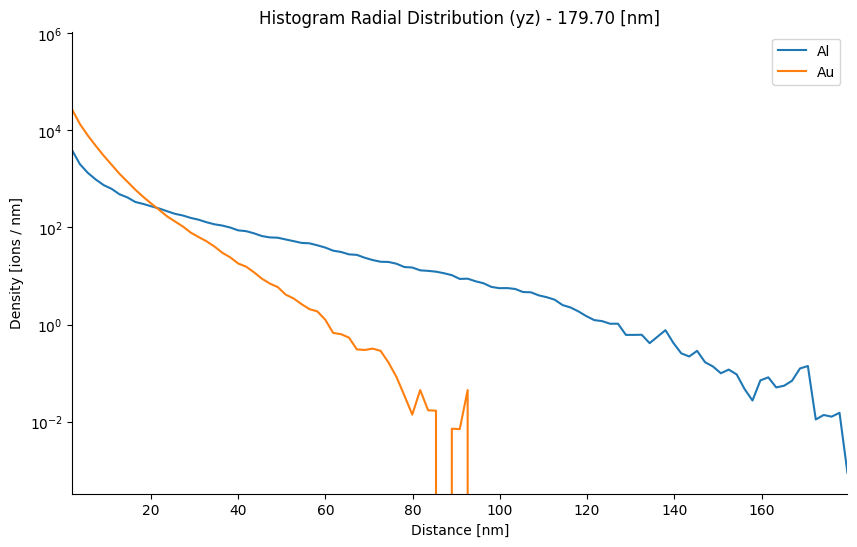

In [9]:
import math
# Very small 100 nm (to more clearly show trend)
maximum = max(-min_radial, max_radial)

fig, ax = plt.subplots()
for i, ion in enumerate(sorted(data, key=sort_by_mass)):
    print(i, ion)
    radius = np.linalg.norm(data[ion]['collisions'][:, 1:], axis=1)
    plot_radial_distribution_hist(ax, radius, maximum, ion)
ax.set_title('Histogram Radial Distribution (yz) - %.2f [nm]' % maximum)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(2, maximum)
# ax.set_ylim(0, 60000)
ax.legend()
ax.set_xlabel('Distance [nm]')
ax.set_ylabel('Density [ions / nm]')
fig.set_size_inches(10, 6)
fig.savefig(os.path.join(IMAGE_DIRECTORY, 'sic-radial-hist.png'), transparent=False, dpi=300)